# Separating GLORYs Bottom and Surface Temperature

This notebook will read in the collection of GLORYs files, create an index for bottom and surface observations, extract bottom and surface temperatures (or other variables if edited from `theato`), and finally save the extracted values as new files for additional use.

In [14]:

####  Libraries  ####
import xarray as xr
import dask
import os
import numpy as np
import geopandas as gpd
import regionmask

# Check
import pkg_resources

# Check if xarray is installed
xarray_installed = 'xarray' in {pkg.key for pkg in pkg_resources.working_set}
print(f"xarray installed: {xarray_installed}")

# Check if netCDF4 is installed
netcdf4_installed = 'netCDF4' in {pkg.key for pkg in pkg_resources.working_set}
print(f"netCDF4 installed: {netcdf4_installed}")

# Check if h5netcdf is installed
h5netcdf_installed = 'h5netcdf' in {pkg.key for pkg in pkg_resources.working_set}
print(f"h5netcdf installed: {h5netcdf_installed}")

import sys
print(sys.executable)

# Paths to resources
box_path = "/Users/aallyn/Library/CloudStorage/Box-Box/"
# lobecol_path = f"{box_path}Mills Lab/Projects/Lobster ECOL/Spatial_Defs/"
glorys_file = f"{box_path}RES_Data/GLORYs/NW_Atl_MonthlyTemps/NW_Atl_MonthlyTemps_FullTS.nc" # on box
# glorys_path = "../Baukus_GLORYS_data/" # Baukas, smaller area
# local_poly_paths = "../local_data/Shapefiles/"

# glorys_path = "../GLORYS_data/"
# fpaths_glorys = os.listdir(glorys_path)

# Check files are there
#os.listdir("../GLORYS_data")
# fpaths_glorys[0:6]

xarray installed: True
netCDF4 installed: False
h5netcdf installed: True
/Users/aallyn/GitHub/lobSDM/.venv/bin/python


### Pull the indices for deepest and surface layers

For this step we only need one file open since the depth is unchanging across files.

In [15]:
# Open one file to get depth indices
# glorys_single = xr.open_mfdataset(f"{glorys_path}{fpaths_glorys[0]}", combine = "by_coords", parallel = True, engine = 'h5netcdf')
glorys_single = xr.open_mfdataset(f"{glorys_file}", combine = "by_coords", parallel = True, engine = 'h5netcdf')

glorys_single

<xarray.Dataset> Size: 4GB
Dimensions:    (time: 372, depth: 38, latitude: 154, longitude: 235)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude  (longitude) float32 940B -75.75 -75.67 -75.58 ... -56.33 -56.25
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 4GB dask.array<chunksize=(372, 38, 154, 235), meta=np.ndarray>
Attributes: (12/15)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...
    copernicusmarine_version:      1.3.3

# Isolate Bottom and Surface Temperatures

The following function searches for the largest depth value that is non-NA. It then pulls that index number for each lat/lon location. This can then be used to pull values for other variables for those depths. After getting those indices, we then just manually change the depth index to 0 for all locations to coincide with a surface index.

In [16]:
# Identify Bottom Indices
# find bottom temp for any netcdf with depth
def find_deepest_depth_indices(ds, variable_id, y_coord, x_coord, depth_coord, maxDepth = 2000):


    # Subset up to an optional max depth
    kwargs = {depth_coord: slice(0, maxDepth)}
    bottom_400 = ds.sel(**kwargs)

    # First get the vertical True/False of valid values
    idx = bottom_400[variable_id].isel(time=0).isnull()
    idx_vals = idx.values


    if len(bottom_400[variable_id][x_coord].dims) == 2:
        multiIndex = True
    else:
        multiIndex = False

    if multiIndex == True:
        dims0 = bottom_400[y_coord].dims[0]
        dims1 = bottom_400[y_coord].dims[1]
    else:
        dims0 = y_coord
        dims1 = x_coord


    # Create the initial final array to store indices (integer type)
    depth_indices = np.zeros((len(idx[y_coord][dims0]), len(idx[x_coord][dims1]))).astype(int)

    # Now find the deepest depth where values are True and store in indices array
    for i in range(len(bottom_400[dims1].values)):
        for j in range(len(bottom_400[dims0].values)):
            located = np.where(idx_vals[:, j, i] == False)
            try:
                depth_indices[j, i] = int(located[-1][-1])
            except IndexError:
                depth_indices[j, i] = 1

    # Gather as a DataArray
    ind = xr.DataArray(depth_indices, dims=[dims0, dims1])

    return ind

In [17]:
# Pull the bottom indices from the single glorys file
glorys_bottom_idx = find_deepest_depth_indices(
    ds = glorys_single, 
    variable_id = 'thetao', 
    x_coord = 'longitude', 
    y_coord = 'latitude', 
    depth_coord = 'depth', 
    maxDepth = 2000)
print(glorys_bottom_idx)

# Modify this slightly to have the index be [0] to eventually grab surface values
glorys_surface_idx = glorys_bottom_idx.copy()
glorys_surface_idx[:] = 0
print(glorys_surface_idx)

<xarray.DataArray (latitude: 154, longitude: 235)> Size: 290kB
array([[ 5,  6,  6, ..., 37, 37, 37],
       [ 5,  5,  5, ..., 37, 37, 37],
       [ 5,  5,  5, ..., 37, 37, 37],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1]])
Dimensions without coordinates: latitude, longitude
<xarray.DataArray (latitude: 154, longitude: 235)> Size: 290kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Dimensions without coordinates: latitude, longitude


### Open the Full Collection

Now we can open the full GLORYS collection and pull values for the "bottom" layer and "surface" layer across the full time dimension.

In [18]:
# Load all of the Glorys year as one file

# Load GLORYs
# fpaths_glorys_full = []
# for file in fpaths_glorys:
#     if file.endswith(".nc"):
#         fpaths_glorys_full.append(f"{glorys_path}{file}")
# fpaths_glorys_full[0:6]

# # Lazy-load the data itself using xr.open_mfdataset
# glorys_all = xr.open_mfdataset(fpaths_glorys_full, combine = "by_coords", parallel = True, engine = 'h5netcdf')
glorys_all = xr.open_mfdataset(f"{glorys_file}", combine = "by_coords", parallel = True, engine = 'h5netcdf')
glorys_all

<xarray.Dataset> Size: 4GB
Dimensions:    (time: 372, depth: 38, latitude: 154, longitude: 235)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude  (longitude) float32 940B -75.75 -75.67 -75.58 ... -56.33 -56.25
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 4GB dask.array<chunksize=(372, 38, 154, 235), meta=np.ndarray>
Attributes: (12/15)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...
    copernicusmarine_version:      1.3.3

### Use Indices to Pull Bottom and then Surface Values

This is the step where we actually pull the values out.

<xarray.Dataset> Size: 108MB
Dimensions:      (latitude: 154, longitude: 235, time: 372)
Coordinates:
    depth        (latitude, longitude) float32 145kB 6.441 7.93 ... 1.541 1.541
  * latitude     (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude    (longitude) float32 940B -75.75 -75.67 -75.58 ... -56.33 -56.25
  * time         (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    bottom_temp  (time, latitude, longitude) float64 108MB dask.array<chunksize=(372, 154, 235), meta=np.ndarray>

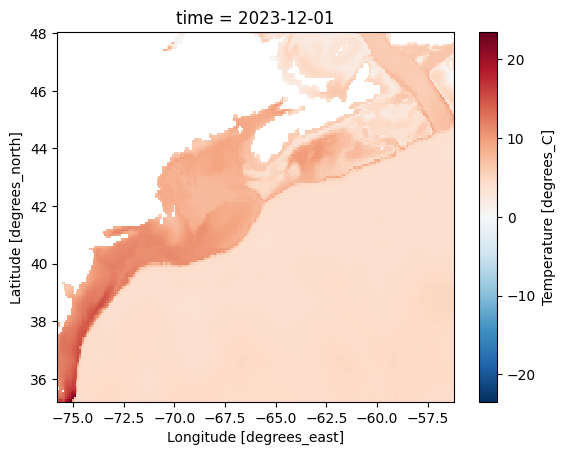

In [19]:
# Bottom first
# use kwargs to pull values for those indices
kwdepth = {'depth': glorys_bottom_idx}
var_array = glorys_all['thetao']


# Now index the values out
dsSel = var_array.isel(**kwdepth)
ds = dsSel.to_dataset()
ds.thetao.isel(time = -1).plot()

# Refocus/Reshape
bottom_ds = ds.rename_vars({"thetao" : "bottom_temp"})
bottom_ds

Next, surface.

<xarray.Dataset> Size: 108MB
Dimensions:       (latitude: 154, longitude: 235, time: 372)
Coordinates:
    depth         (latitude, longitude) float32 145kB 0.494 0.494 ... 0.494
  * latitude      (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude     (longitude) float32 940B -75.75 -75.67 ... -56.33 -56.25
  * time          (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    surface_temp  (time, latitude, longitude) float64 108MB dask.array<chunksize=(372, 154, 235), meta=np.ndarray>

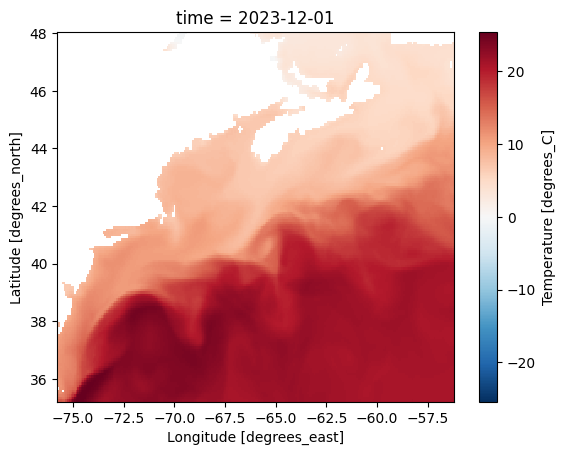

In [20]:
# use kwargs to pull values for those indices
kwdepth = {'depth': glorys_surface_idx}
var_array = glorys_all['thetao']


# Now index the values out
dsSel = var_array.isel(**kwdepth)
ds = dsSel.to_dataset()
ds.thetao.isel(time = -1).plot()

# Refocus/Reshape
surface_ds = ds.rename_vars({"thetao" : "surface_temp"})
surface_ds

## Swap Depth from Coordinate to Variable

This step drops depth as a coordinate and changes it to a variable so people can see what the depth was used for "bottom" down the line. This keeps a record of what the depth was that we've taken values from.

In [21]:
# Drop the depth dimension where it exists, then rebuild.
# Takes the first layer for depth to grab surface measurements in the case of SST and bottom in the case where there
def depth_to_var(xr_ds, var, depth_var = "depth", t_coord = "time", x_coord = "longitude", y_coord = "latitude"):
    """Pull out data as an array, drop depth as a dimension, rebuild xr.array and add depth calues as a variable. 
    Need to pull surface measurement from surface data arrays so depth coordinate
    becomes unnecessary.
    
    Args:
        xr_ds      : xr.ArrayDataset
        var (str)  : String indicating variable to pull and process
    
    """
    
    # Pull the coordinates to keep
    time     = xr_ds.coords[t_coord]
    x_coords = xr_ds.coords[x_coord]
    y_coords = xr_ds.coords[y_coord]

    # Take the data values out as an array
    var_vals = xr_ds[var].values 
    depth_vals = xr_ds[depth_var].values

    # Rebuild an xr.array for the variable we're pulling out
    var_array = xr.DataArray(var_vals, coords = [time, y_coords, x_coords])

    # Another for depth
    depth_array = xr.DataArray(depth_vals, coords = [y_coords, x_coords])

    # Put them all together as one thing
    no_depth_ds = xr.Dataset({
        var  : var_array,
        "depth"  : depth_array})



    return no_depth_ds

In [22]:
# Do the reshaping
bottom_ds_new = depth_to_var(
    xr_ds = bottom_ds, 
    var = "bottom_temp", 
    depth_var = "depth", 
    t_coord = "time", 
    x_coord = "longitude", 
    y_coord = "latitude")

bottom_ds_new

surface_ds_new = depth_to_var(
    xr_ds = surface_ds, 
    var = "surface_temp", 
    depth_var = "depth", 
    t_coord = "time", 
    x_coord = "longitude", 
    y_coord = "latitude")

surface_ds_new

<xarray.Dataset> Size: 108MB
Dimensions:       (time: 372, latitude: 154, longitude: 235)
Coordinates:
  * time          (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
  * latitude      (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude     (longitude) float32 940B -75.75 -75.67 ... -56.33 -56.25
Data variables:
    surface_temp  (time, latitude, longitude) float64 108MB 14.74 14.7 ... nan
    depth         (latitude, longitude) float32 145kB 0.494 0.494 ... 0.494

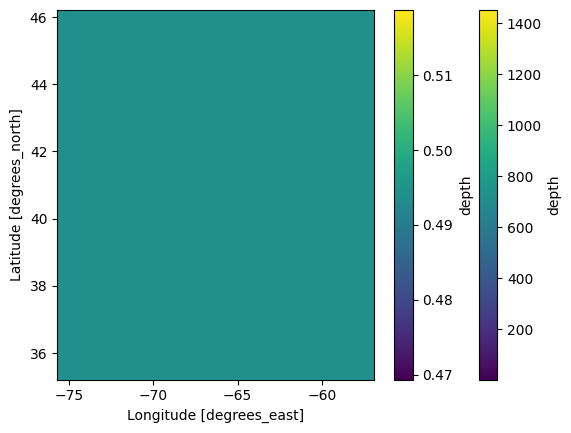

In [33]:
# Plot bottom 
p1 = bottom_ds_new.depth.plot()

# Plot surface
p2 = surface_ds_new.depth.plot()


# Save Bottom and Surface Temperature as Standalone Files

In [24]:
# Below is some code to save things out by year. For our purpose, though, I think we are just going to want to save out a single file and we also only need monthly averages
# btemp_monthly = bottom_ds_new.resample(time = "ME").mean()
# print(btemp_monthly)
bottom_ds_new.to_netcdf(f"{box_path}RES_Data/GLORYs/NW_Atl_MonthlyTemps/BT.nc")

# sstemp_monthly = surface_ds_new.resample(time = "ME").mean()
# print(sstemp_monthly)
surface_ds_new.to_netcdf(f"{box_path}RES_Data/GLORYs/NW_Atl_MonthlyTemps/SST.nc")

# btemp_out = f"{box_path}RES_Data/GLORYs/NE_Shelf_BTemp/"
# # Group by year
# for year, subset in bottom_ds_new.groupby('time.year'):
    
#     # Save each year's data to a separate NetCDF file
#     subset.to_netcdf(f'{btemp_out}{year}.nc')

# sstemp_out = f"{box_path}RES_Data/GLORYs/NE_Shelf_SSTemp/"
# # Group by year
# for year, subset in surface_ds_new.groupby('time.year'):
    
#     # Save each year's data to a separate NetCDF file
#     subset.to_netcdf(f'{sstemp_out}{year}.nc')